In [23]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [24]:
import numpy as np

from __future__ import division

import lal
import lalsimulation

from pycbc.conversions import *
import pycbc.types 
import pycbc.noise
import pycbc.psd
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
from astropy import cosmology
import pycbc.filter
from pycbc.filter import sigmasq
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.filter import resample_to_delta_t, highpass, matched_filter
from pycbc.frame import read_frame
import pylab



from pycbc.catalog import Merger

from scipy.stats import norm
from scipy import interpolate
from numpy import pi
from numpy import arange
from scipy import constants
import matplotlib.pyplot as plt
import seaborn as sns

import math
import matplotlib.pyplot as plt
from statistics import mean, stdev


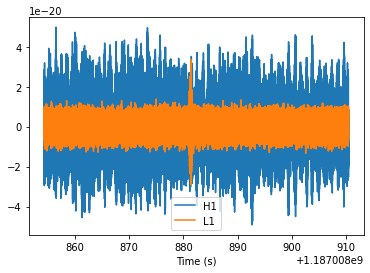

In [25]:
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame


merger = Merger("GW170817")
strain, stilde = {}, {}
for ifo in ['H1', 'L1']:
   # We'll download the data and select 256 seconds that includes the event time
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                    start_time=merger.time - 32,
                   end_time=merger.time + 32,
                   check_integrity=False)
    
   # Read the detector data and remove low frequency content
    strain[ifo] = highpass(ts, 15)
# Remove time corrupted by the high pass filter
    strain[ifo] = strain[ifo].crop(4, 4)
# Also create a frequency domain version of the data
    stilde[ifo] = strain[ifo].to_frequencyseries()

#print (strain.delta_t)
    pylab.plot(strain[ifo].sample_times, strain[ifo], label=ifo)
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()


pylab.show()
 
#_____________________________________________________________________

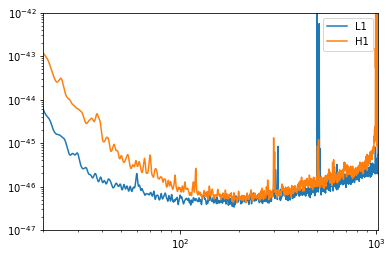

In [26]:
#---------------------------Estimate PSD from your data---------------------------------------------------
from pycbc.psd import interpolate, inverse_spectrum_truncation
psds = {}
for ifo in ['L1', 'H1']:
 # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
# We then interpolate the PSD to the desired frequency step.
    psds[ifo] = interpolate(strain[ifo].psd(2), stilde[ifo].delta_f)
   # We explicitly control how much data will be corrupted by overwhitening the data later on
# In this case we choose 2 seconds.
    psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 * strain[ifo].sample_rate),
low_frequency_cutoff=15.0, trunc_method='hann')
    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [27]:
##########_______________Matched filtering_____________________
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy
# We will try different component masses and see which gives us the largest
masses = numpy.arange(1.3, 1.5, .01)
# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []
for m in masses:
   #Generate a waveform with a given component mass; assumed equal mass,nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2", mass1=m, mass2=m, f_lower=20, delta_f=stilde[ifo].delta_f)
 
    hp.resize(len(stilde[ifo]))
   # Matched filter the data and find the peak
    max_snr, max_time = {}, {}
for ifo in ['L1', 'H1']:
    snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)
       # The complex SNR at the peak
    snr = snr.time_slice(merger.time - 1, merger.time + 1)
    _, idx = snr.abs_max_loc()
    max_snr[ifo] = snr[idx]
       # The time of the peak
    max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
snrs.append(max_snr)
   # Keep track of only the loudest peak
if network_snr > nsnr:
    tmax, hmax, mmax, smax = max_time, hp, m, max_snr
    nsnr = network_snr
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)
print( "with a signal to noise ratio of " + str(nsnr) +"for the H1 detector")   
# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift. print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)

We found the best Mass1=Mass2 was 1.49 solar masses (detector frame)
with a signal to noise ratio of 6.731929183018605for the H1 detector


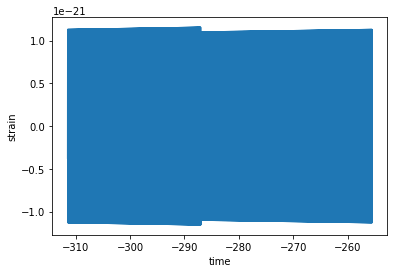

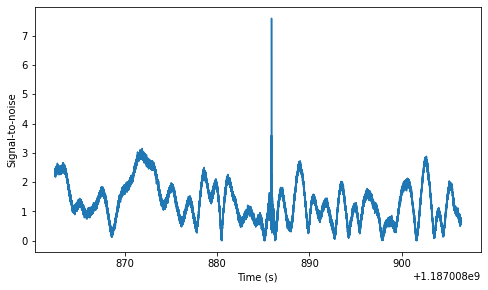

A signal is found at:1187008885.8931642s with a signal to noise ratio of  7.60217868147744


In [28]:
m = 1.49
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15.0)

# Resize the vector
hp.resize(len(conditioned))


# This function rotates the vector by a fixed amount of time.
template = hp .cyclic_time_shift(hp.start_time)



pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

ifo = 'L1'                            
conditioned = strain[ifo]

snr = matched_filter(template, conditioned,
                     psd=psds[ifo], low_frequency_cutoff=15)

snr = snr.crop(4 + 4, 4)


pylab.figure(figsize=[8, 4.5])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("A signal is found at:{}s with a signal to noise ratio of  {}".format(time, abs(snrp)))

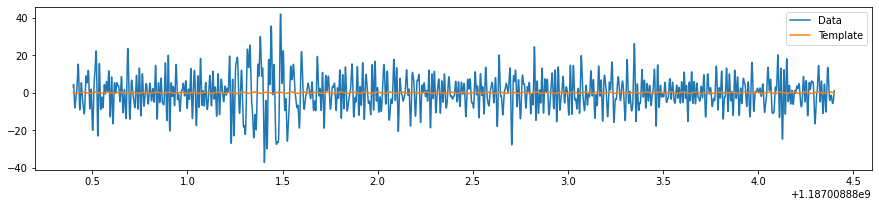

In [29]:
from pycbc.filter import sigma

dt = time - conditioned.start_time

aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=15)
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time
 
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()
tapered = aligned.highpass_fir(15, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()


white_data = white_data.highpass_fir(15., 512).lowpass_fir(80, 512)
white_template = white_template.highpass_fir(15, 512).lowpass_fir(80, 512)
white_data = white_data.time_slice(merger.time-2, merger.time+2)
white_template = white_template.time_slice(merger.time-2, merger.time+2)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

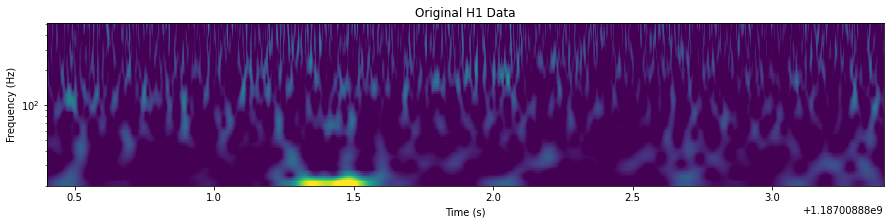

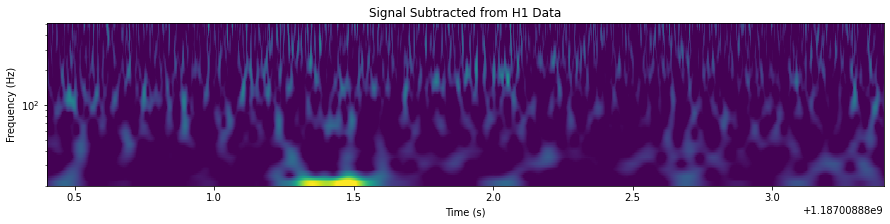

In [30]:
subtracted = conditioned - aligned

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                      logfsteps=100,
                        qrange=(8, 8),
                          frange=(20, 512))
    
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)

In [31]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096
snrs = {}
Snr_list = []

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="TaylorT4",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)


mass1 = numpy.arange(5, 15, 0.10) #mass range bewteen 5 to 15 Solar mass
mass2 = mass1

for i in range(len(mass1)):

    m = mass1[i] # Solar masses
    sp, sc = get_td_waveform(approximant="TaylorT4",
                     mass1=m,
                     mass2=m,
                     f_lower=f_low,
                     delta_t=1.0/sample_rate)
        
    # Resize the waveforms to the same length
    tlen = max(len(sp), len(hp))
    sp.resize(tlen)
    hp.resize(tlen)
    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / sp.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

    m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
    # modify the match data so we can use it in the graph

    Snr_list.append(m)


snrs[i] = Snr_list


pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs[i], 'bo')
pylab.ylabel('Match')
pylab.xlabel('mass')
pylab.show()

TypeError: ignored

In [ ]:

'''
Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral density (PSD) of that data. Test whether there is any gravitational wave signal present in the data or not? For this test, you can assume the GW signals can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW
'''

In [32]:
d = np.load('noise_ts_4096Hz.npy')

#After loading the data we must give it the shape of a TimeSeries 
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d


No handles with labels found to put in legend.


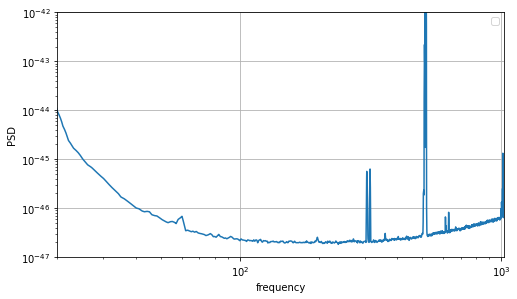

In [33]:
'''
Estimating the power spectral density of the given data
'''
from pycbc.psd import welch, interpolate
psds = interpolate(welch(d), 1.0 / d.duration)


pylab.figure(figsize=(8,4.5))

pylab.loglog(psds.sample_frequencies, psds)
pylab.ylabel('PSD')
pylab.xlabel('frequency')
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)
pylab.grid()
pylab.legend()

Test whether if there is any gravitational wave signal present or not!

In [34]:
'''
For this test, one can chose set of template waveforms and compute SNR time series. 
For this case, I chose only the gravitational waveform temaple by chosing m1 = m2 = 10M_odot
'''

import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
import pylab
flow = 30 #Hz
stilde = data.to_frequencyseries()
masses = arange(5,12,0.5)

for mass in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                    mass1=mass, mass2=mass,
                             f_lower=flow, delta_f=stilde.delta_f)
  
  hp.resize(len(stilde))  
  snr = pycbc.filter.matched_filter(hp, stilde, psd=psds,
                                      low_frequency_cutoff=flow)

  snr = snr[len(snr) // 4: len(snr) * 3 // 4]

  peak = abs(snr).numpy().argmax()
  snrp = snr[peak]
  if(snrp > 8):
    print('The equal masses of {} give an SNR greater that 8 in {}'.format(mass, abs(snrp)) )
  else:
    print('There was no SNR larger than 8. The peak SNR at the mass of {} was {}'.format(mass, abs(snrp)))

There was no SNR larger than 8. The peak SNR at the mass of 5.0 was 5.215891772105199
There was no SNR larger than 8. The peak SNR at the mass of 5.5 was 5.163342296489468
There was no SNR larger than 8. The peak SNR at the mass of 6.0 was 5.100873161342923
There was no SNR larger than 8. The peak SNR at the mass of 6.5 was 5.6857317618465695
There was no SNR larger than 8. The peak SNR at the mass of 7.0 was 5.092314227417557
There was no SNR larger than 8. The peak SNR at the mass of 7.5 was 4.798273484351692
There was no SNR larger than 8. The peak SNR at the mass of 8.0 was 5.9348137468235205
There was no SNR larger than 8. The peak SNR at the mass of 8.5 was 5.565711108686226
There was no SNR larger than 8. The peak SNR at the mass of 9.0 was 5.664784674730153
There was no SNR larger than 8. The peak SNR at the mass of 9.5 was 5.877523831266216
There was no SNR larger than 8. The peak SNR at the mass of 10.0 was 5.14255771068566
There was no SNR larger than 8. The peak SNR at the 

In [ ]:
No SNR large enough to colclude gravitational wave detection

Comment : So, we see that maximum Signal to noise ratio is not crossing the thresold value(= 8), hence we can conclude this
    time seris contains no significant signal. 
    

In [ ]:
'''
Problem 2: Part 2
'''

In [ ]:
'''Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD. Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.
'''

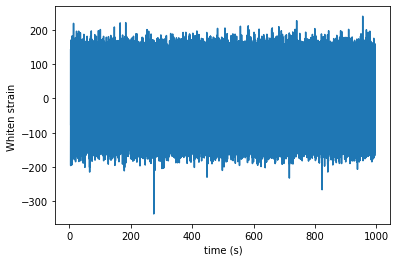

In [35]:
#Whitening the data

from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab

white_strain = (data.to_frequencyseries() / psds ** 0.5).to_timeseries()
white_strain = white_strain.crop(4, 4)

pylab.plot(white_strain.sample_times, white_strain)
pylab.ylabel('Whiten strain ')
pylab.xlabel('time (s)')
pylab.show()

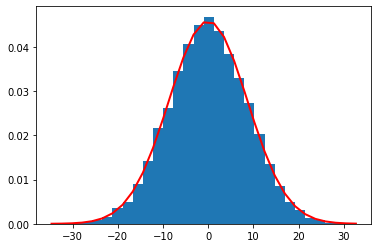

In [36]:
import math
import matplotlib.pyplot as plt
from statistics import mean, stdev

mu, sigma, shape = mean(white_data), stdev(white_data), white_data.shape[0]
s = np.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

Commemts:Hence, we can see that the noise follows the Gaussian distribution. 

In [ ]:

'''In gravitational wave data analysis, we consider that the noise is stationary Gaussian. But in reality, the stationary assumption does not hold. Can you think of a test to show that the stationarity does not hold?

'''

4096


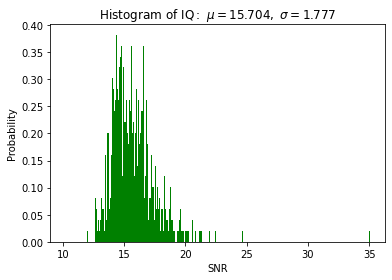

In [37]:
# 'hp' wave form in frequency domain
from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigmasq
import matplotlib.pyplot as plt
from statistics import mean, stdev
from scipy.stats import norm

hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0)




max = 1000

slice_data= len(data)/max
slice_data= int(slice_data)
print(slice_data)

SNRlist = []
for i in range(0,max):
  data_chunk = data[i*slice_data:(i+1)*slice_data]
  psd = interpolate(welch(data_chunk),1.0/ d.duration)

  psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk),hp.delta_f)

  optSNR = (pycbc.filter.sigmasq(hp, psds))**0.5
  
  SNRlist.append(optSNR) 
# Plotting histogram
plt.hist(SNRlist, 500, color = "green", density=True)

# Plotting Best Fit
(mu, sigma) = norm.fit(SNRlist)
y = norm.pdf(25, mu, sigma)
l = plt.plot(25, y, "r--", linewidth=2)

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.xlabel("SNR")
plt.ylabel("Probability")

# show plot 
plt.show()

Comment: We can see that the SNR of tha same waveform is different when we consider different chunks of data. Hence, we can see the noise in the real detector is not completely stationary. 

The noise is not gaussian

Excercises 3

In [40]:
'First we compute the optimal SNR ver total mass of the system. '
from pycbc.filter import sigmasq
import pycbc.noise
import pycbc.psd
import pylab
from pycbc.waveform import get_fd_waveform
import numpy as np




m1 = np.arange(2, 2000, 1)
m2 = m1
SNR_list_aLIGO = []



# Taking aLIGO design sensitivity
flow = 4.0
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd_aLIGO = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd = psd_aLIGO

psd.data[:int(flow/delta_f)] = np.inf
psd.data[-1] = np.inf

for i in range(len(m1)):
    hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=m1[i],
                         mass2=m2[i],
                         delta_f=1.0/(16.0) ,
                         distance = 1000, 
                         f_lower=5.0, f_final = 2048.0)    #d = 4000 Mpc
    
    
    #SNR1 = (pycbc.filter.sigmasq(hp, psd))**0.5
    SNR1 = (np.sum((4*hp*np.conj(hp)*hp.delta_f/psd).data).real)**0.5
    SNR_list_aLIGO.append(SNR1)
    
    
SNR_list_aLIGO = np.array(SNR_list_aLIGO)


Text(0.5, 0, 'Freq')

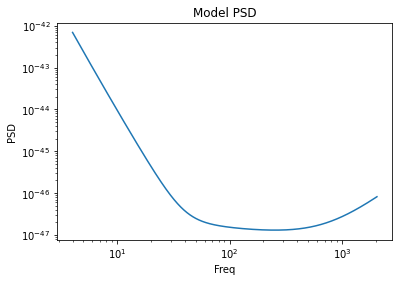

In [44]:
import pycbc.psd

flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf


pylab.loglog(psd.sample_frequencies, psd)


pylab.title("Model PSD")
pylab.ylabel('PSD')
pylab.xlabel('Freq')

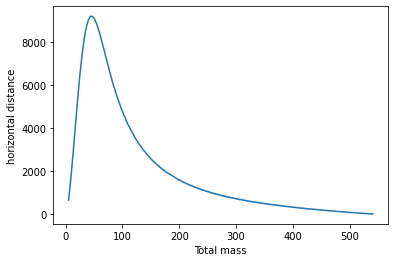

No handles with labels found to put in legend.


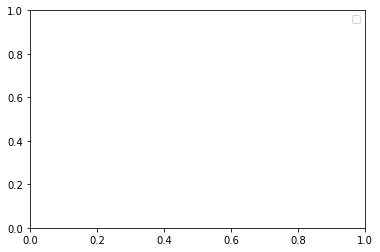

In [45]:
'''
Calculation of horzon distance
'''


'''
As we know that SNR is inversely proportional to distance. 
In the previous SNR plot distnace was 1000 Mpc. 
Hence, In order to find horizon distance we need to find the distnace for which SNR is 8
'''
from pycbc.filter import sigmasq

flow = 4.0 #Hz

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

# using previous threshold to check for gravitational waves
  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()

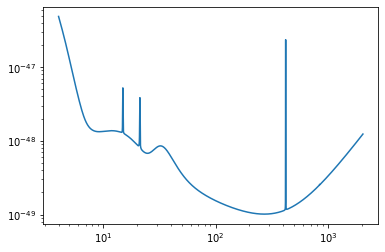

In [46]:
'''
Lets chose two poins from the horizon distance plot(marked in '*' in the plot)
'''
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16
flen = int(2048.0/ (delta_f)) + 1

psd = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = np.inf #set the value outside the frequency range to infinity
psd.data[-1] = np.inf

# print(psd.sample_frequencies)

pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

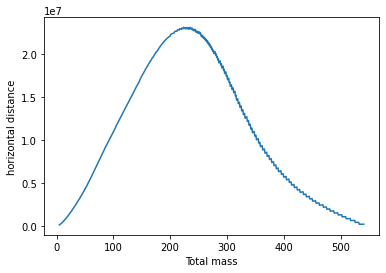

In [47]:
flow = 4.0 #Hz

interval = 1
masses = np.arange(5,550,interval)

a = []
b = []

for m in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                              mass1=m, mass2=m,
                              f_lower=flow, 
                              delta_f=delta_f,
                              distance = 100)

  SNR = (pycbc.filter.sigmasq(hp, psd))*0.5

  if SNR > 8: 
    a.append(SNR/8)
    b.append(m)

pylab.plot(b, a)
pylab.ylabel('horizontal distance')
pylab.xlabel('Total mass')
pylab.show()